In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
%matplotlib inline

Using TensorFlow backend.


# Loading Dataset

In [2]:
stock_exchange_mk = pd.read_csv('data_mse_mse_historic_data_active.csv', sep='\t', parse_dates=['Date'])

In [3]:
df = pd.DataFrame(stock_exchange_mk)
df["stock_id"] = df["stock_id"].astype('category')
df.columns = df.columns.str.lower()

# Missing Dates

In [4]:
stocks = df.stock_id.unique()
dates_all = pd.period_range(min(df.date), max(df.date)).to_timestamp()
idx = pd.MultiIndex.from_product((dates_all, stocks), names=['date', 'stock_id'])
df_new = df.set_index(['date', 'stock_id']).reindex(idx).reset_index()

### Drop Unnecessary Dates

In [5]:
df_list = []
for stock in df.stock_id.unique():
    each_df = df[df.stock_id == stock]
    groupby_stock = each_df.groupby([pd.PeriodIndex(data=each_df.date, freq='D'), 'stock_id'])
    df_list.append(groupby_stock)

In [6]:
stock_name = []
stock_start_date = []
for i in df_list:
    name = min(i.date)[0][1]
    stock_name.append(name)
    date = min(i.date)[0][0]
    stock_start_date.append(date)
    
start_date = dict(zip(stock_name, stock_start_date))

In [7]:
start_date_df = pd.DataFrame.from_dict(start_date, orient='index', dtype='datetime64[ns]', columns=['start_date'])

In [8]:
start_date_df.head()

,start_date
ALK,1997-01-09
BESK,2002-10-10
FERS,1999-04-15
GRNT,1999-10-28
KMB,1997-05-15


In [9]:
df_clean = df_new.set_index('stock_id').join(start_date_df, lsuffix='_filter', on='stock_id').reset_index()

In [10]:
df_clean.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
1,BESK,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-10-10
2,FERS,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-15
3,GRNT,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-10-28
4,KMB,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-05-15


In [11]:
print(df_clean.shape, df_new.shape, df.shape)

(189860, 20) (189860, 19) (43441, 19)


In [12]:
df_drop = df_clean[df_clean['date'] >= df_clean['start_date']]

In [13]:
min(df_drop.date[df_drop.stock_id == 'BESK'])

Timestamp('2002-10-10 00:00:00')

### Filling NaN Values

In [14]:
df_sorted = df_drop.sort_values(by=['stock_id', 'date'], ascending=True)
test = df_sorted.drop_duplicates()
print(df_sorted.shape, test.shape)

(164754, 20) (164754, 20)


In [15]:
df_sorted.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
22,ALK,1997-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09


In [16]:
column_average = df_sorted['average']
df_sorted.drop('average', axis=1, inplace=True)
df_sorted.insert(5, 'average', column_average)

In [17]:
df_sorted

,stock_id,date,open,high,low,average,close,volume,adj close,quantity,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
22,ALK,1997-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189771,VITA,2020-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-10-13
189793,VITA,2020-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-10-13
189815,VITA,2020-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-10-13
189837,VITA,2020-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-10-13


In [18]:
# average will be equal to close price because there is no transactions on Nan 
# open, high, low are fulfil with close price because there is no transaction next day
df_sorted[['open', 'high', 'low', 'average', 
           'close']] = df_sorted[['open', 'high', 'low', 'average', 
                                  'close']].assign(close=df_sorted['close'].ffill()).bfill(axis=1)

# quantity, volume and volume total should be 0 also because of no transactions
df_sorted[['volume', 'quantity', 'volume total', 
           'change %']] = df_sorted[['volume', 'quantity', 'volume total', 'change %']].fillna(0)

# drop adj close same as close
df_sorted = df_sorted.drop('adj close', axis=1)

In [19]:
df_sorted = df_sorted[df_sorted.columns.drop(list(df_sorted.filter(regex='ratio')))]

In [20]:
df_sorted.head()

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


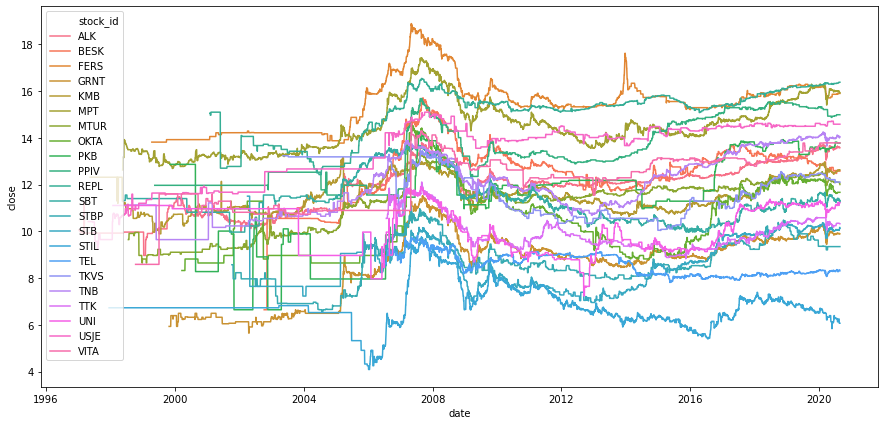

In [21]:
plt.figure(figsize=(15,7))
sns.lineplot(x="date", y=np.log2(df_sorted.close), hue="stock_id", data=df_sorted)
plt.show()

In [22]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

## feature engineering

In [23]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [24]:
df_final = df_sorted.copy()

### Date Extraction

In [25]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
df_final['sales_elapsed'] = df_final.date - df_final.start_date
df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [26]:
display_all(df_final.tail(10).T)

,189661,189683,189705,189727,189749,189771,189793,189815,189837,189859
stock_id,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA
date,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
open,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
high,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
low,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
average,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
close,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
volume,0,0,0,0,0,0,0,0,0,0
quantity,0,0,0,0,0,0,0,0,0,0
change %,0,0,0,0,0,0,0,0,0,0


In [27]:
df_final = df_final.drop('start_date', axis=1)

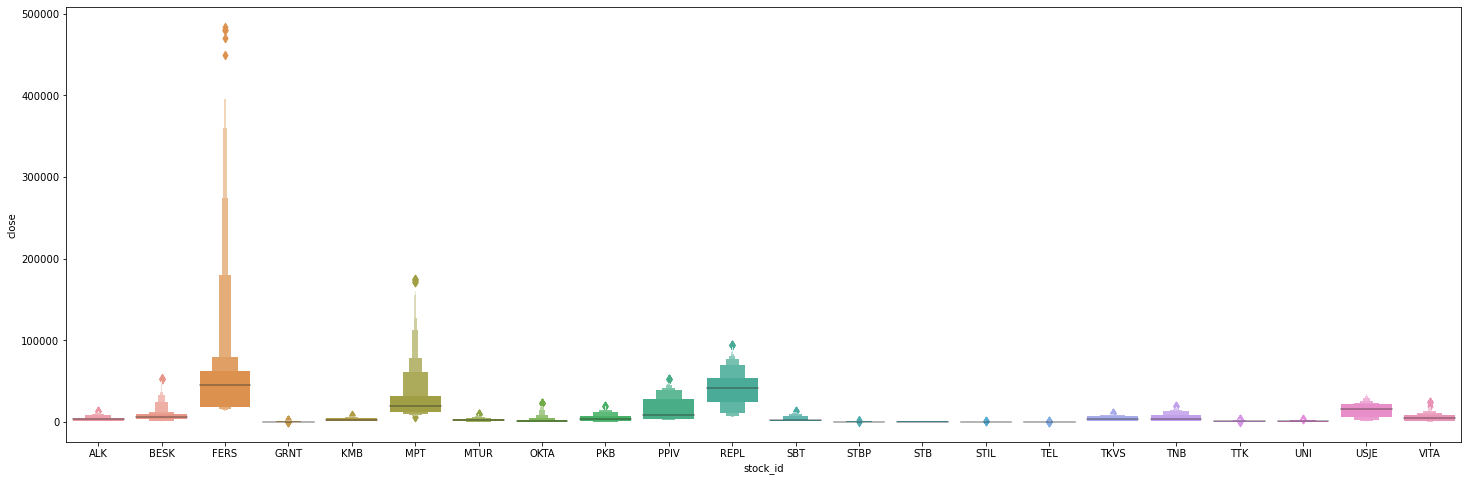

In [28]:
plt.figure(figsize=(25, 8))
sns.boxenplot('stock_id', df_sorted.close, data=df_final)
plt.show()

### rolling

In [29]:
df_final = df_final.set_index('date')

In [30]:
df_final.head(3)

,stock_id,open,high,low,average,close,volume,quantity,change %,volume total,...,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,...,9,False,False,False,False,False,False,31,False,0
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,10,False,False,False,False,False,False,31,False,1
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,11,False,False,False,False,False,False,31,False,2


In [32]:
#rolloing list for 30 days target
sum_7_qty_by_stock = []
sum_30_qty_by_stock = []
volumne_moving_avg_7 = []
volumne_moving_avg_30 = []
close_moving_avg_7 = []
close_moving_avg_30 = []
close_volatility_7 = []
close_volatility_30 = []
max_7_days = []
max_30_days = []
min_7_days = []
min_30_days = []
change_by_stock_daily_prev = []
profitability_daily_prev = []
ratio_prev = []

In [33]:
for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum_7 = df_final[df_final.stock_id == stock].quantity.rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum_7)
    # sum quantity over last 30 days
    qty_sum_30 = df_final[df_final.stock_id == stock].quantity.rolling(30).sum()
    sum_30_qty_by_stock.append(qty_sum_30)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on volumne over last 30 days
    volumne_ma_30 = df_final[df_final.stock_id == stock].volume.rolling(30).mean()
    volumne_moving_avg_30.append(volumne_ma_30)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # moving average on close price over last 30 days
    close_ma_30 = df_final[df_final.stock_id == stock].close.rolling(30).mean()
    close_moving_avg_30.append(close_ma_30)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).std().shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # volatility in close price over last 30 days
    close_volatility_30_by_stock = df_final[df_final.stock_id == stock].close.rolling(30).std().shift()
    close_volatility_30.append(close_volatility_30_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # max close price in last 30 days
    max_30_by_stock = df_final[df_final.stock_id == stock].close.rolling(30).max()
    max_30_days.append(max_30_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).min()
    min_7_days.append(min_7_by_stock)
    # min close price in last 30 days
    min_30_by_stock = df_final[df_final.stock_id == stock].close.rolling(30).min()
    min_30_days.append(min_30_by_stock)
    # ratio overall will be average price devided by max closing price over all time
    max_close_price = df_final[df_final.stock_id == stock].close.max()
    ratio_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(1) / max_close_price
    ratio_prev.append(ratio_by_stock_prev)
    
    # daily_change new feature
    today = df_final[df_final.stock_id == stock].close.shift(1)
    yesterday = today.shift(2)
    change_by_stock =  today / yesterday - 1
    change_by_stock_daily_prev.append(change_by_stock)
    
    # daily_profitability_prev new feature
    profitability_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(1) - df_final[df_final.stock_id == stock].open.shift(1)
    profitability_daily_prev.append(profitability_by_stock_prev)

In [34]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_2 = itertools.chain.from_iterable(sum_30_qty_by_stock)
flattened_list_2 = list(chain_object_2)

chain_object_3 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_4 = itertools.chain.from_iterable(volumne_moving_avg_30)
flattened_list_4 = list(chain_object_4)

chain_object_5 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_5 = list(chain_object_5)

chain_object_6 = itertools.chain.from_iterable(close_moving_avg_30)
flattened_list_6 = list(chain_object_6)

chain_object_7 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_7 = list(chain_object_7)

chain_object_8 = itertools.chain.from_iterable(close_volatility_30)
flattened_list_8 = list(chain_object_8)

chain_object_9 = itertools.chain.from_iterable(max_7_days)
flattened_list_9 = list(chain_object_9)

chain_object_10 = itertools.chain.from_iterable(max_30_days)
flattened_list_10 = list(chain_object_10)

chain_object_11 = itertools.chain.from_iterable(min_7_days)
flattened_list_11 = list(chain_object_11)

chain_object_12 = itertools.chain.from_iterable(min_30_days)
flattened_list_12 = list(chain_object_12)

ratio_object = itertools.chain.from_iterable(ratio_prev)
flattened_list_13 = list(ratio_object)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily_prev)
flattened_list_14 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily_prev)
flattened_list_15 = list(profitability_object)

In [35]:
rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1,
                               'sum_30_qty_by_stock':flattened_list_2,
                               'moving_avg_volume_7_days':flattened_list_3,
                               'moving_avg_volume_30_days':flattened_list_4,
                               'moving_avg_close_7_days':flattened_list_5,
                               'moving_avg_close_30_days':flattened_list_6,
                               'volatility_7_days':flattened_list_7,
                               'volatility_30_days':flattened_list_8,
                               'max_7_days':flattened_list_9,
                               'max_30_days':flattened_list_10,
                               'min_7_days':flattened_list_11,
                               'min_30_days':flattened_list_12,
                               'ratio_overall_prev':flattened_list_13,
                               'change_daily_prev':flattened_list_14,
                               'profitability_daily_prev':flattened_list_15}
                             )

In [36]:
print(df_final.shape, rolling_7_days.shape)

(164754, 25) (164754, 15)


In [37]:
df_7_days = pd.concat([df_final.reset_index(), rolling_7_days], axis=1)

In [38]:
ratio_7_days = []
ratio_30_days = []

# Calculating ratios up to 7 and 30 days
for stock in df_7_days.stock_id.unique():
    ratio_7 = df_7_days[df_7_days.stock_id == stock].average.shift(1) / df_7_days[df_7_days.stock_id == stock].max_7_days
    ratio_30 = df_7_days[df_7_days.stock_id == stock].average.shift(1) / df_7_days[df_7_days.stock_id == stock].max_30_days
    ratio_7_days.append(ratio_7)
    ratio_30_days.append(ratio_30)


In [39]:
chain_object_16 = itertools.chain.from_iterable(ratio_7_days)
flattened_list_16 = list(chain_object_16)

chain_object_17 = itertools.chain.from_iterable(ratio_30_days)
flattened_list_17 = list(chain_object_17)

ratios_df = pd.DataFrame({'ratio_7_days':flattened_list_16,
                          'ratio_30_days':flattened_list_17
                         }
                        )

In [40]:
df_7_days = pd.concat([df_final.reset_index(), ratios_df], axis=1)

In [41]:
### Add column based on data analysis

# 1 day
df_7_days['prevopen_1'] = df_7_days.groupby(['stock_id'])['open'].shift(2)
#(open - prevopen) / prevopen
df_7_days['returnsOpenPrevRaw1'] = (df_7_days.open.shift(1) - df_7_days.prevopen_1) / df_7_days.prevopen_1

#10 days
df_7_days['prevopen_7'] = df_7_days.groupby(['stock_id'])['open'].shift(8)
df_7_days['returnsOpenPrevRaw_7'] = (df_7_days.open.shift(1) - df_7_days.prevopen_7) / df_7_days.prevopen_7

#Rate of change

# pct_chg = lambda x:x.pct_change()
# df_7_days['pct'] = df_7_days.groupby(['stock_id'])['close'].apply(pct_chg)

#Z-score
# zscore = lambda x:(x-x.mean())/x.std()
# df_7_days['z_score'] = df_7_days.groupby(['stock_id'])['close'].apply(zscore)

#percentile transformation
#rollrank = lambda x: x.rolling(200, min_periods=20).apply(lambda x:pd.Series(x).rank(pct=True)[0])
#df_7_days['percentile'] = df_7_days.groupby(['stock_id'])['volume'].apply(rollrank)

In [42]:
display_all(df_7_days.tail(25).T)

,164729,164730,164731,164732,164733,164734,164735,164736,164737,164738,164739,164740,164741,164742,164743,164744,164745,164746,164747,164748,164749,164750,164751,164752,164753
date,2020-08-01 00:00:00,2020-08-02 00:00:00,2020-08-03 00:00:00,2020-08-04 00:00:00,2020-08-05 00:00:00,2020-08-06 00:00:00,2020-08-07 00:00:00,2020-08-08 00:00:00,2020-08-09 00:00:00,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
stock_id,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA
open,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
high,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
low,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
average,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
close,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
volume,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
quantity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
change %,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### setting ALK dataset for training, validation and test

In [43]:
alk_df = df_7_days[df_7_days.stock_id == 'ALK']

In [44]:
to_drop = ['date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'quantity', 'change %', 'volume total']

In [45]:
alk_df = alk_df.dropna()

In [46]:
alk_df.drop(to_drop, axis=1, inplace=True)

### split dataset

In [47]:
X, y = alk_df.drop('close', axis=1), alk_df.close

In [48]:
scaler = StandardScaler()
normalizer = Normalizer()

In [51]:
def split_vals(dataset, n_test):
    n = dataset.shape[0] - n_test
    train_valid = dataset[:n].copy()
    return train_valid[:-n_test].copy(), train_valid[:n_test].copy(), dataset[-n_test:]

n_test = 30
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8541, 21), (30, 21), (30, 21), (8541,), (30,), (30,))

In [52]:
import math

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(model, X_train, y_train, X_valid, y_valid):
    res = [np.sqrt(mean_squared_error(model.predict(X_train), y_train)), 
           np.sqrt(mean_squared_error(model.predict(X_valid), y_valid)),
           model.score(X_train, y_train),
           model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
    print(res)

### Fine-tune RandomForestRegressor

In [53]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

Wall time: 1.26 s
[40.08443830643006, 124.95831805046032, 0.9998077178760668, 0.9203565244113927, 0.998669781218676]


In [54]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [55]:
fi = rf_feat_importance(model, X_train)
fi[:10]

,cols,imp
17,prevopen_1,0.545403
19,prevopen_7,0.233109
14,sales_elapsed,0.157230
0,sale_year,0.051204
15,ratio_7_days,0.004633
16,ratio_30_days,0.004095
20,returnsOpenPrevRaw_7,0.001770
5,sale_dayofyear,0.000923
2,sale_week,0.000429
1,sale_month,0.000416


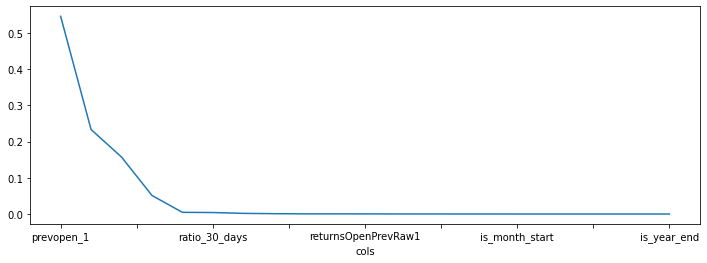

In [56]:
fi.plot('cols', 'imp', figsize=(12,4), legend=False);

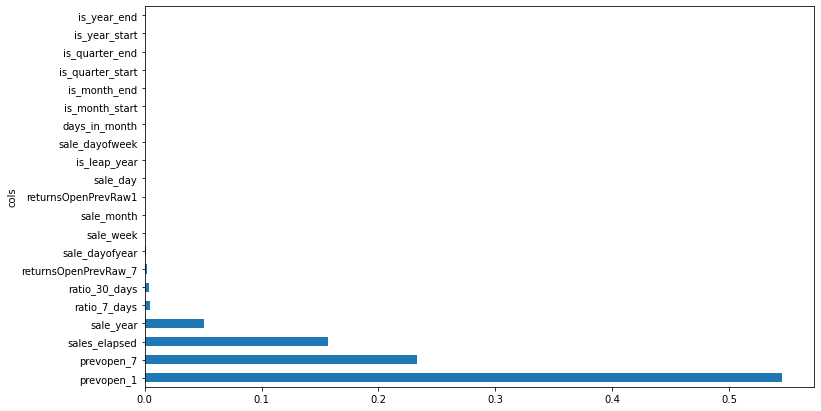

In [57]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

In [59]:
to_keep = fi[fi.imp>0.0005].cols;
len(to_keep)

8

In [60]:
df_keep = alk_df[to_keep].copy()
X_train_keep, X_valid_keep, X_test_keep = split_vals(df_keep, n_test)

In [63]:
model_keep = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_keep.fit(X_train_keep, y_train)
print_score(model_keep, X_train_keep, y_train, X_valid_keep, y_valid)

Wall time: 1.11 s
[41.27711396322003, 140.64666129465473, 0.9997961052915737, 0.8991028923708873, 0.9985492667577748]


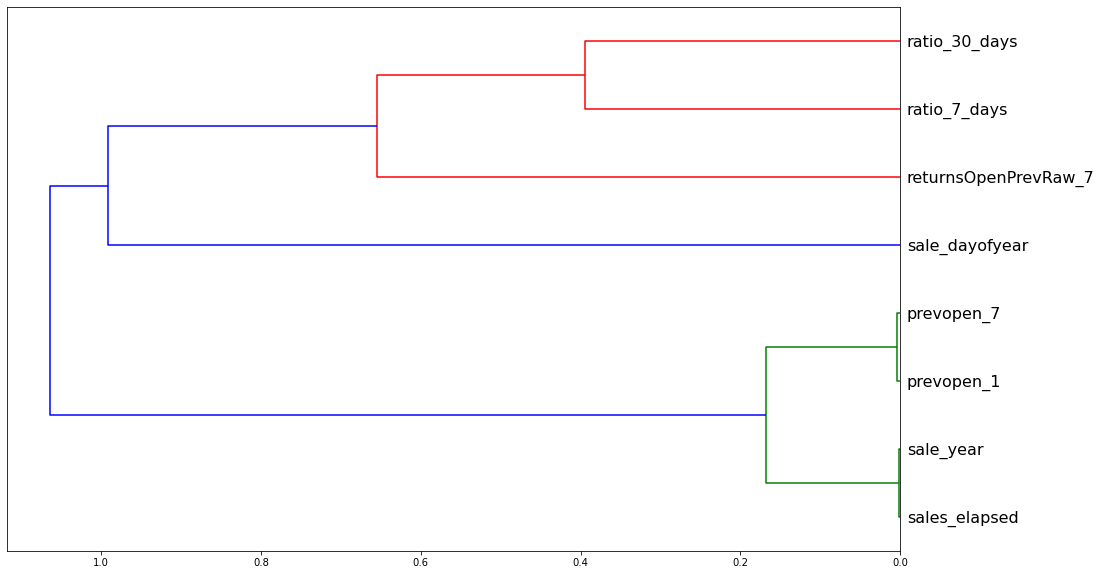

In [64]:
from scipy.cluster import hierarchy as hc

corr = np.round(sp.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [67]:
def get_oob(df):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    x, _, _ = split_vals(df, n_test)
    m.fit(x, y_train)
    return m.oob_score_

In [68]:
get_oob(df_keep)

0.9985608438257331

In [70]:
for c in ('prevopen_1', 'prevopen_7', 'sale_year', 'sales_elapsed'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

prevopen_1 0.9987451022992451
prevopen_7 0.998696070003247
sale_year 0.9984676951102943
sales_elapsed 0.9983255387452425


### extrapolation

In [85]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_test] = 0

C:\Users\Gj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
X_ext, y_ext = df_ext.drop('is_valid', axis=1), df_ext.is_valid

In [87]:
X_train_ext, X_valid_ext, X_test_ext = split_vals(X_ext, n_test)
y_train_ext, y_valid_ext, y_test_ext = split_vals(y_ext, n_test)

In [88]:
model_ext = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_ext.fit(X_train_ext, y_train_ext)
model_ext.oob_score_

Wall time: 356 ms


0.9784548162839541

In [89]:
fi = rf_feat_importance(model_ext, X_train_ext); fi[:10]

,cols,imp
2,sales_elapsed,0.822211
7,sale_dayofyear,0.091010
3,sale_year,0.047680
1,prevopen_7,0.020515
6,returnsOpenPrevRaw_7,0.008043
5,ratio_30_days,0.007477
0,prevopen_1,0.002074
4,ratio_7_days,0.000991


In [90]:
feats=['sales_elapsed', 'prevopen_7']
(X_train_ext[feats]/1000).describe()

,sales_elapsed,prevopen_7
count,8541.000000,8541.000000
mean,4.299000,4.390471
std,2.465719,2.883271
min,0.029000,0.500000
25%,2.164000,1.830000
50%,4.299000,4.200000
75%,6.434000,5.400000
max,8.569000,14.150000


In [91]:
X_train_ext.columns

Index(['prevopen_1', 'prevopen_7', 'sales_elapsed', 'sale_year',
       'ratio_7_days', 'ratio_30_days', 'returnsOpenPrevRaw_7',
       'sale_dayofyear'],
      dtype='object')

In [92]:
X_train_ext.drop(feats, axis=1, inplace=True)
m_drop = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
m_drop.fit(X_train_ext, y_train_ext);
m_drop.oob_score_

0.9608455207454382

In [94]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train_sub, X_valid_sub, X_test_sub = split_vals(df_subs, n_test)
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    m.fit(X_train_sub, y_train_ext)
    print(f)
    print_score(m, X_train_sub, y_train_ext, X_valid_sub, y_valid_ext)

sales_elapsed
[0.0038160335644294176, 0.05645794895318108, 0.995839553225238, 0.0, 0.9687623774244329]
prevopen_7
[0.001874158281974584, 0.030276503540974917, 0.9989964751498062, 0.0, 0.9912417431697566]


### final model

In [101]:
X, y = alk_df.drop('close', axis=1), alk_df.close

In [105]:
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8541, 21), (30, 21), (30, 21), (8541,), (30,), (30,))

In [106]:
model_final = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_final.fit(X_train, y_train)
print_score(model_final, X_train, y_train, X_valid, y_valid)

Wall time: 1.24 s
[40.66918238686726, 151.13696189218572, 0.9998020670083138, 0.883490526941282, 0.9985990539468501]


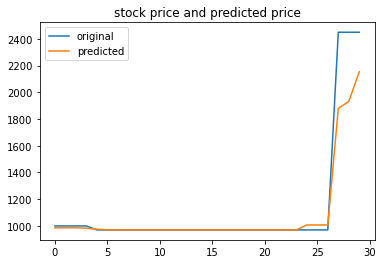

In [107]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, model_final.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [109]:
ranfor_pred = model_final.predict(X_test)

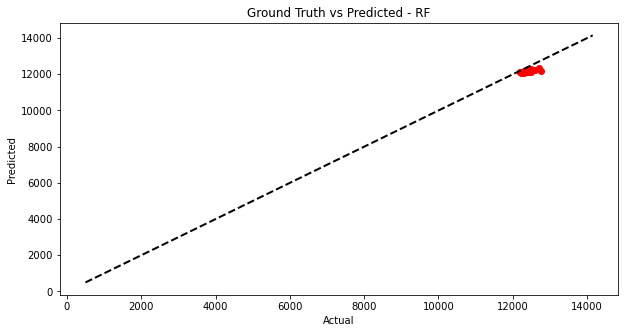

In [112]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, ranfor_pred, color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### qty forecast

In [113]:
alk_df_qty = df_7_days[df_7_days.stock_id == 'ALK']
alk_df_qty = alk_df_qty.dropna()
to_drop_qty = ['date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'close', 'change %', 'volume total']
alk_df_qty.drop(to_drop_qty, axis=1, inplace=True)

In [114]:
X_qty, y_qty = alk_df_qty.drop('quantity', axis=1), alk_df_qty.quantity

In [115]:
X_train_qty, X_valid_qty, X_test_qty = split_vals(X_qty, n_test)
y_train_qty, y_valid_qty, y_test_qty = split_vals(y_qty, n_test)
X_train_qty.shape, X_valid_qty.shape, X_test_qty.shape, y_train_qty.shape, y_valid_qty.shape, y_test_qty.shape

((8541, 21), (30, 21), (30, 21), (8541,), (30,), (30,))

In [ ]:
%%time

parametars = {
    'n_estimators': [30, 50, 100, 150, 200, 300, 400, 500],
    'min_samples_leaf': [1, 3, 5, 10, 25]
}

model_qty = RandomForestRegressor(n_jobs=-1, max_features=0.5)
clf = GridSearchCV(model_qty, parametars)
clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best score = {clf.best_score_}')

In [116]:
model_qty = RandomForestRegressor(n_jobs=-1, n_estimators=200, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_qty.fit(X_train_qty, y_train_qty)
print_score(model_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

Wall time: 5.5 s
[179.12894655334654, 50.69839902140237, 0.8964737996141183, 0.868583107293469, 0.23105901577034238]


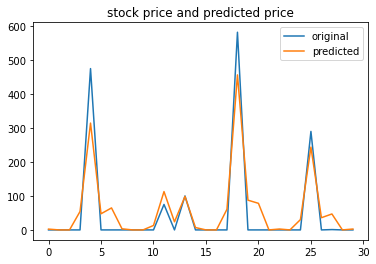

In [117]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, model_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [118]:
ranfor_pred_qty = model_qty.predict(X_test_qty)

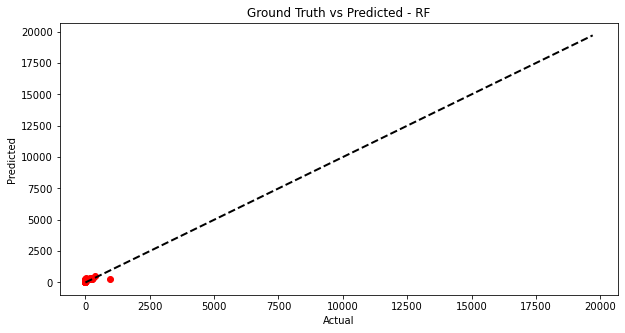

In [119]:
plt.figure(figsize=(10,5))

plt.scatter(y_test_qty, ranfor_pred_qty, color='red')
plt.plot([y_train_qty.min(), y_train_qty.max()], [y_train_qty.min(), y_train_qty.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### XGBOOST

In [138]:
xgb_reg = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.01, n_estimators=950)

In [139]:
xgb_reg.fit(X_train, y_train)
print_score(xgb_reg, X_train, y_train, X_valid, y_valid)

[60.217250764291265, 130.76122712087385, 0.9995660605305922, 0.912787680468046]


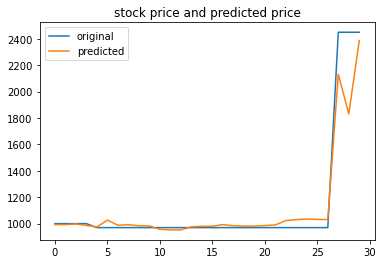

In [141]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, xgb_reg.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [147]:
xgb_reg_qty = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.01, n_estimators=2000)

In [148]:
xgb_reg_qty.fit(X_train_qty, y_train_qty)
print_score(xgb_reg_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

[228.49576474325943, 54.95458016258107, 0.8315484387512454, 0.8455917529590458]


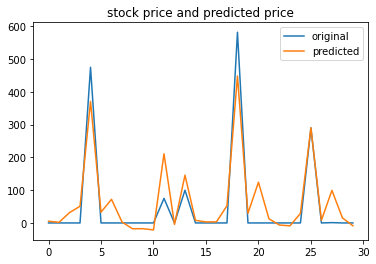

In [149]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, xgb_reg_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()